##Importing Lib

In [1]:
import subprocess
subprocess.run(['pip', 'install', 'imblearn'])
subprocess.run(['pip', 'install', 'feature-engine'])
subprocess.run(['pip', 'install', '-U', 'imbalanced-learn'])
subprocess.run(['pip', 'install', 'xgboost'])


CompletedProcess(args=['pip', 'install', 'xgboost'], returncode=0)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from datetime import datetime
from sklearn.compose import TransformedTargetRegressor


###MODELS SETUP

In [3]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV


from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin

##Auxiliar functions

###PIPELINE

In [4]:
def data_treatment(df):
    df_with_na = df.isna()
    df = df.dropna(subset=['device_id'])
    cols_to_category = ['transaction_id', 'merchant_id', 'user_id', 'card_number']
    df[cols_to_category] = df[cols_to_category].astype(str)
    df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
    df['transaction_amount'] = df['transaction_amount'].astype(float)
    df['has_cbk'] = df['has_cbk'].astype(bool)
    return df


def dt_engineering(df):
    df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')

    df["month"] = df['transaction_date'].dt.month
    df["day"] = df['transaction_date'].dt.day
    df["hour"] = df['transaction_date'].dt.hour
    df["min"] = df['transaction_date'].dt.minute
    df['sec'] = df['transaction_date'].dt.second

    df = df.drop(columns='transaction_date', axis=1)

    return df


NUMERIC_FEATURES = ['transaction_amount', 'month', 'day', 'hour', 'min', 'sec']
CATEGORICAL_FEATURES = ['transaction_id', 'merchant_id', 'user_id', 'card_number']
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
TARGET = 'has_cbk'


def label_encode_columns(df, columns):
    le = LabelEncoder()
    df_encoded = df.copy()

    for column in columns:
        if column in df.columns:
            df_encoded[column] = le.fit_transform(df[column])

    return df_encoded


def display_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    balanced = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f'Accuracy score: {accuracy}')
    print(f'F1 score: {f1score}')
    print(f'Balanced accuracy: {balanced}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')


##DATA MODELING

In [5]:
df = pd.read_csv('C:\Users\nando\OneDrive\Área de Trabalho\CLOUDWALK_API\frauds.csv')

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (655803912.py, line 1)

In [ ]:
df_pre_processed = data_treatment(df)
df_pre_processed = dt_engineering(df)


<ipython-input-4-446b19cdf044>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cols_to_category] = df[cols_to_category].astype(str)
<ipython-input-4-446b19cdf044>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
<ipython-input-4-446b19cdf044>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [ ]:
columns_to_encode = ['transaction_id', 'merchant_id', 'user_id', 'card_number']
df_pre_processed =  label_encode_columns(df_pre_processed, columns_to_encode)

In [ ]:
df['has_cbk'] = df['has_cbk'].map({0: False, 1: True})

In [ ]:
NUMERIC_FEATURES = ['transaction_amount', 'month', 'day', 'hour', 'min', 'sec']
CATEGORICAL_FEATURES = ['transaction_id', 'merchant_id', 'user_id', 'card_number']
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
TARGET = 'has_cbk'

x = df_pre_processed[FEATURES]
y = df_pre_processed[TARGET]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

In [ ]:
scaler = StandardScaler()

x_train_scaled_norm = pd.DataFrame(scaler.fit_transform(x_train), index = x_train.index, columns = x_train.columns)
x_test_scaled_norm = pd.DataFrame(scaler.fit_transform(x_test), index = x_test.index, columns = x_test.columns)

In [ ]:
forest = RandomForestClassifier(class_weight='balanced')

forest.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [ ]:
# metricas do modelo de Regressão Logística

y_pred = forest.predict(x_test)

display_metrics(y_test, y_pred)

Accuracy score: 0.9078125
F1 score: 0.46846846846846846
Balanced accuracy: 0.6604389086595492
Precision: 0.7878787878787878
Recall: 0.3333333333333333


TUNNED MODEL

In [ ]:
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
x_train_smote, y_train_smote = smote.fit_resample(x_train_scaled_norm, y_train)

# Apply SMOTE to the test data
x_test_smote, y_test_smote = smote.fit_resample(x_test_scaled_norm, y_test)

In [ ]:
forest = RandomForestClassifier(class_weight='balanced')

forest.fit(x_train_smote, y_train_smote)


RandomForestClassifier(class_weight='balanced')

In [ ]:
# metricas do modelo novo de Regressão Logística

y_pred = forest.predict(x_test_smote)

display_metrics(y_test_smote, y_pred)

Accuracy score: 0.7704626334519573
F1 score: 0.7490272373540856
Balanced accuracy: 0.7704626334519573
Precision: 0.8261802575107297
Recall: 0.6850533807829181


Hipertunning the model

In [ ]:
best_forest_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1
)

# Train the model on the SMOTE-resampled training set
best_forest_model.fit(x_train_smote, y_train_smote)

RandomForestClassifier(n_estimators=50)

In [ ]:
# metricas do modelo novo de Regressão Logística

y_pred = best_forest_model.predict(x_test_smote)

display_metrics(y_test_smote, y_pred)

Accuracy score: 0.7935943060498221
F1 score: 0.7738791423001949
Balanced accuracy: 0.7935943060498221
Precision: 0.8556034482758621
Recall: 0.7064056939501779


DECISION TREE MODEL

In [ ]:
gradient = GradientBoostingClassifier()

gradient.fit(x_train, y_train)

GradientBoostingClassifier()

In [ ]:
y_pred = gradient.predict(x_test)

display_metrics(y_test, y_pred)

Accuracy score: 0.921875
F1 score: 0.5689655172413792
Balanced accuracy: 0.7070900629619491
Precision: 0.868421052631579
Recall: 0.4230769230769231


In [ ]:
gradient = GradientBoostingClassifier()

gradient.fit(x_train_smote, y_train_smote)

GradientBoostingClassifier()

In [ ]:
y_pred = gradient.predict(x_test_smote)

display_metrics(y_test_smote, y_pred)

Accuracy score: 0.7695729537366548
F1 score: 0.7795744680851063
Balanced accuracy: 0.7695729537366549
Precision: 0.7471451876019576
Recall: 0.8149466192170819


In [ ]:
# Set the parameters
params = {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}

# Create an instance of GradientBoostingClassifier with the specified parameters
gradient = GradientBoostingClassifier(**params)

# Assuming x_train_smote and y_train_smote are your training data
gradient.fit(x_train_smote, y_train_smote)

GradientBoostingClassifier(max_depth=10, min_samples_leaf=4,
                           min_samples_split=10, n_estimators=200)

In [ ]:
y_pred = gradient.predict(x_test_smote)

display_metrics(y_test_smote, y_pred)

Accuracy score: 0.797153024911032
F1 score: 0.8017391304347827
Balanced accuracy: 0.797153024911032
Precision: 0.7840136054421769
Recall: 0.8202846975088968


Top 10 variáveis mais importantes:
transaction_amount: 0.3996124050479227
hour: 0.20276247815940757
transaction_id: 0.10331388692427777
card_number: 0.06853819814252797
day: 0.06800263813210992
merchant_id: 0.06730322111290532
user_id: 0.04016893187063824
sec: 0.03435435437159467
min: 0.01594388623861566
month: 0.0


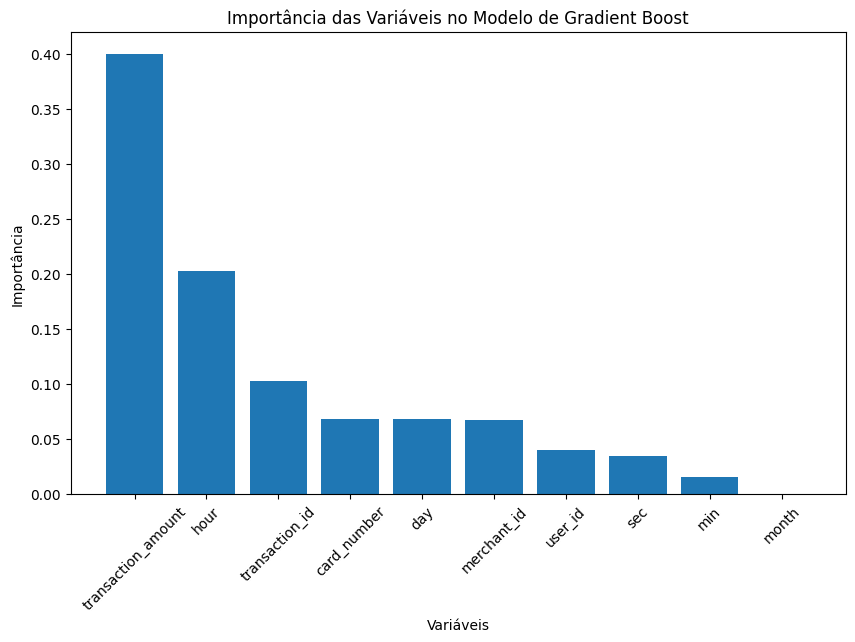

In [ ]:
gradient = GradientBoostingClassifier()
gradient.fit(x_train_smote, y_train_smote)

feature_importance = gradient.feature_importances_

sorted_idx = feature_importance.argsort()[::-1]


print("Top 10 variáveis mais importantes:")
for f in range(10):
    print(f"{x_train_smote.columns[sorted_idx[f]]}: {feature_importance[sorted_idx[f]]}")

plt.figure(figsize=(10, 6))
plt.bar(range(x_train_smote.shape[1]), feature_importance[sorted_idx], align="center")
plt.xticks(range(x_train_smote.shape[1]), x_train_smote.columns[sorted_idx], rotation=45)
plt.xlabel("Variáveis")
plt.ylabel("Importância")
plt.title("Importância das Variáveis no Modelo de Gradient Boost")
plt.show()

In [ ]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(x_test, y_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = xgb_model.predict(x_test_smote)

display_metrics(y_test_smote, y_pred)

Accuracy score: 0.5
F1 score: 0.0
Balanced accuracy: 0.5
Precision: 0.0
Recall: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##DEPLOYMENT

In [ ]:
recorte = df.sample(frac=0.2, random_state=42)

In [ ]:
recorte_pre_processed = data_treatment(recorte)
recorte_pre_processed = dt_engineering(recorte)

<ipython-input-4-446b19cdf044>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cols_to_category] = df[cols_to_category].astype(str)
<ipython-input-4-446b19cdf044>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
<ipython-input-4-446b19cdf044>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [ ]:
columns_to_encode = ['transaction_id', 'merchant_id', 'user_id', 'card_number']
recorte_pre_processed =  label_encode_columns(recorte, columns_to_encode)

In [ ]:
recorte_pre_processed['has_cbk'] = recorte_pre_processed['has_cbk'].map({0: False, 1: True})


In [ ]:
NUMERIC_FEATURES = ['transaction_amount', 'month', 'day', 'hour', 'min', 'sec']
CATEGORICAL_FEATURES = ['transaction_id', 'merchant_id', 'user_id', 'card_number']
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
TARGET = 'has_cbk'

x_recorte = df_pre_processed[FEATURES]
y_recorte = df_pre_processed[TARGET]

In [ ]:
x_recorte_scaled_norm = pd.DataFrame(scaler.fit_transform(x_recorte), index = x_recorte.index, columns = x_recorte.columns)

In [ ]:
y_pred = gradient.predict(x_recorte_scaled_norm)

display_metrics(y_recorte, y_pred)

Accuracy score: 0.7680525164113785
F1 score: 0.48184357541899436
Balanced accuracy: 0.8172448466566113
Precision: 0.3314121037463977
Recall: 0.8823529411764706
